This script asks whether there is a significant difference in the slope of the relationship between evidence accumulation and starting point bias between the rule-driven and stimulus-driven conditions, for the section "Rule- and stimulus-based biases exhibited distinct computational signatures."

In [1]:
#clear memory
rm(list=ls())

library(dplyr)
library(tidyr)
library(lme4)
library(lmerTest)
library(ggplot2)
library(blme)
library(emmeans)

switch(Sys.info()[['sysname']],
       Windows = PROJECT_DIR <- paste0('C:/Users/',Sys.getenv('USERNAME'),
                              '/Dropbox/Goldlab/AuditoryPriors/'),
       Darwin = PROJECT_DIR <- '~/Dropbox/Goldlab/AuditoryPriors/'
)

setwd(paste0(PROJECT_DIR,'data processing'))

DATA_FILE = 'params_blockW_forR_01-Nov-2021.csv'

param_df <- read.table(DATA_FILE,sep=',', header=TRUE, 
                    stringsAsFactors=FALSE,na.strings = 'NaN')
head(param_df)

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Warning message:
"package 'lmerTest' was built under R version 4.0.4"

Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Warning message:
"package 'ggplot2' was built under R version 4.0.4"
Warning message:
"package 'blme' was built under R version 4.0.5"
Warning message:
"package 'emmeans' was built under R version 4.0.4"


,subject,block,blocknum,B,nondectime_Bias,nondectime_No,t,tau_Adapt,tau_Bias,umixturecoef,...,z_No,z_Nonolog,v_diff,z_diff,v_BiasHH,v_BiasLL,v_Biasdiff,z_BiasHH,z_BiasLL,z_Biasdiff
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AdL,priorOnly,1,0.9715937,NA,0.1583011,0.6647727,NA,NA,0.04370345,...,0.399670563,0.5986085,1.631192,0.3153712,NA,NA,NA,NA,NA,NA
2,AdR,priorOnly,1,0.7712041,NA,0.2983822,0.1864977,NA,NA,0.02101964,...,-0.064369745,0.4839131,1.160783,0.4789212,NA,NA,NA,NA,NA,NA
3,AdR,pretoneOnly,2,1.0193112,-0.1304806,0.4533451,0.6519824,13.929159,1.901462,0.01700377,...,0.403590069,0.5995499,NA,NA,1.15637468,-1.15637468,2.31274936,-0.08608592,0.08608592,-0.17217184
4,AkB,priorOnly,1,0.9572631,NA,0.2545406,1.8498360,NA,NA,0.01793561,...,-0.006835659,0.4982911,2.935278,0.2326740,NA,NA,NA,NA,NA,NA
5,AkB,pretoneOnly,2,0.9201162,-0.5882514,0.4012478,1.0136500,13.811944,3.203655,0.01489148,...,0.009610032,0.5024025,NA,NA,0.67488633,-0.67488633,1.34977265,-0.07271502,0.07271502,-0.14543004
6,AkB,pretone_pLH,3,0.8076607,0.3508757,0.3561030,1.5740680,8.631048,12.984282,0.02030518,...,NA,0.5000000,5.253422,0.0857925,0.02452666,-0.02452666,0.04905332,0.01785198,-0.01785198,0.03570397


In [2]:
prior_pt <- inner_join(param_df[param_df$block=='priorOnly',
                                c('subject','v_High','v_Low','z_High','z_Low')], #'v_diff','z_diff')],
      param_df[param_df$block=='pretoneOnly',c('subject','v_Bias','z_Bias')],by='subject')           
head(prior_pt)



,subject,v_High,v_Low,z_High,z_Low,v_Bias,z_Bias
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AdR,0.8028281,-0.3579545,0.2343687,-0.24455250,1.0061118,-0.07489965
2,AkB,1.7071202,-1.2281576,0.1728627,-0.05981132,0.6485466,-0.06987707
3,AnK,0.8267580,-0.8510863,0.4797247,-0.20624947,0.6560456,-0.15612509
4,AvL,0.6363923,-0.3609405,0.8173684,-0.18133508,0.5159801,0.07173942
5,BrB,0.7947665,-1.3402627,0.5827298,-0.39395130,1.1082967,-0.32969388
6,BrB2,0.2174539,-0.4655040,0.5137024,0.01818900,1.0659781,-0.08180039


In [3]:
#massage into format we need
prior_ptL <- pivot_longer(prior_pt,v_High:z_Bias,names_to='param',values_to='value')

#add flag for whether z or v, which will become variable names in final table
prior_ptL$vz <- sapply(prior_ptL$param,function(x) substr(x,1,1)) 

#get bias type from param variable
prior_ptL$bias_type <- sapply(prior_ptL$param,function(x) strsplit(x,'_')[[1]][2])
prior_ptL <- pivot_wider(select(prior_ptL,!param),names_from=vz,values_from=value)

In [4]:
#set up variables/factors
prior_ptL$bias_type2 <- ifelse(prior_ptL$bias_type=='Bias','pt','prior') #condition variable

#prior_ptL <- mutate(prior_ptL,z_v=scale(v),z_z=scale(z))
prior_ptL <- mutate(group_by(prior_ptL,bias_type2),z_v=scale(v),z_z=scale(z)) #zscore w/in cond

prior_ptL$bias_type.f <- factor(prior_ptL$bias_type,levels=c('Low','High','Bias'))
contrasts(prior_ptL$bias_type.f) <- contr.sum(3)
contrasts(prior_ptL$bias_type.f)

#reverse helmert will give contrast of high/low, and then rule-driven to stimulus-driven
my_rev_helmert <- contr.helmert(3)/cbind(c(2,2,2),c(3,3,3))
prior_ptL$bias_type.fh <- prior_ptL$bias_type.f
contrasts(prior_ptL$bias_type.fh) <- my_rev_helmert
contrasts(prior_ptL$bias_type.fh)

head(prior_ptL)

Low,1,0
High,0,1
Bias,-1,-1


Low,-0.5,-0.3333333
High,0.5,-0.3333333
Bias,0.0,0.6666667


subject,bias_type,v,z,bias_type2,z_v,z_z,bias_type.f,bias_type.fh
<chr>,<chr>,<dbl>,<dbl>,<chr>,"<dbl[,1]>","<dbl[,1]>",<fct>,<fct>
AdR,High,0.8028281,0.23436869,prior,0.8922784,0.33670984,High,High
AdR,Low,-0.3579545,-0.24455250,prior,-0.2533128,-0.78415349,Low,Low
AdR,Bias,1.0061118,-0.07489965,pt,0.2517041,0.05600936,Bias,Bias
AkB,High,1.7071202,0.17286268,prior,1.7847357,0.19276165,High,High
AkB,Low,-1.2281576,-0.05981132,prior,-1.1121274,-0.35178671,Low,Low
AkB,Bias,0.6485466,-0.06987707,pt,-0.2391649,0.08706978,Bias,Bias


## starting point bias as predictor, evidence accumulation bias as outcome

Note that the biases are z-scored w/in condition (i.e. rule-based, stimulus-based).

In [5]:
#boundary issues so iteratively reduce
bias_lm <- lmer(z_v~z_z*bias_type.fh + (1+z_z|subject),prior_ptL,
                  control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5)))
VarCorr(bias_lm)

boundary (singular) fit: see ?isSingular



 Groups   Name        Std.Dev.   Corr 
 subject  (Intercept) 0.0000e+00      
          z_z         9.5199e-12   NaN
 Residual             7.4071e-01      

In [6]:
bias_lm.zc <- lmer(z_v~z_z*bias_type.fh + (1+z_z||subject),prior_ptL,
                  control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5)))
VarCorr(bias_lm.zc)

boundary (singular) fit: see ?isSingular



 Groups    Name        Std.Dev.
 subject   (Intercept) 0.00000 
 subject.1 z_z         0.00000 
 Residual              0.74071 

In [7]:
bias_lm.2 <- lmer(z_v~z_z*bias_type.fh + (1|subject),prior_ptL,
                  control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5)))
VarCorr(bias_lm.2)

boundary (singular) fit: see ?isSingular



 Groups   Name        Std.Dev.
 subject  (Intercept) 0.00000 
 Residual             0.74071 

In [8]:
#blme fit seems to confirm that intercept variance is near 0, 
#but this is unlikely to impact significance of result
summary(blmer(z_v~z_z*bias_type.fh + (1+z_z|subject),prior_ptL,
              control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5))))
summary(blmer(z_v~z_z*bias_type.fh + (1|subject),prior_ptL,
              control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5))))

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
"Model failed to converge with max|grad| = 4.4051 (tol = 0.002, component 1)"


Cov prior  : subject ~ wishart(df = 4.5, scale = Inf, posterior.scale = cov, common.scale = TRUE)
Prior dev  : 4.8676

Linear mixed model fit by REML ['blmerMod']
Formula: z_v ~ z_z * bias_type.fh + (1 + z_z | subject)
   Data: prior_ptL
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

REML criterion at convergence: 318.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1430 -0.5953 -0.1164  0.4420  4.2356 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 subject  (Intercept) 0.0337   0.1836       
          z_z         0.2268   0.4763   0.01
 Residual             0.4429   0.6655       
Number of obs: 132, groups:  subject, 44

Fixed effects:
                  Estimate Std. Error t value
(Intercept)        0.02782    0.08517   0.327
z_z               -0.45049    0.11552  -3.900
bias_type.fh1      2.19333    0.21353  10.272
bias_type.fh2     -0.01733    0.15252  -0.114
z_z:bias_type.fh1  0.03083    0.23067   0.134
z_z:bias_type.fh2

Cov prior  : subject ~ wishart(df = 3.5, scale = Inf, posterior.scale = cov, common.scale = TRUE)
Prior dev  : 5.4318

Linear mixed model fit by REML ['blmerMod']
Formula: z_v ~ z_z * bias_type.fh + (1 | subject)
   Data: prior_ptL
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

REML criterion at convergence: 304.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6782 -0.5429 -0.0811  0.4940  4.5330 

Random effects:
 Groups   Name        Variance Std.Dev.
 subject  (Intercept) 0.01448  0.1203  
 Residual             0.54113  0.7356  
Number of obs: 132, groups:  subject, 44

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        0.007471   0.084926   0.088
z_z               -0.459165   0.084338  -5.444
bias_type.fh1      2.254913   0.222913  10.116
bias_type.fh2     -0.011207   0.157198  -0.071
z_z:bias_type.fh1 -0.031929   0.225488  -0.142
z_z:bias_type.fh2  0.437027   0.159815   2.735

Correlation of Fixed Effects:

In [9]:
#Since we can't fix convergence, we'll just have to make do. Going to report zero corr model.
summary(bias_lm.zc)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: z_v ~ z_z * bias_type.fh + (1 + z_z || subject)
   Data: prior_ptL
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

REML criterion at convergence: 303.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6982 -0.5356 -0.0572  0.4987  4.6107 

Random effects:
 Groups    Name        Variance Std.Dev.
 subject   (Intercept) 0.0000   0.0000  
 subject.1 z_z         0.0000   0.0000  
 Residual              0.5487   0.7407  
Number of obs: 132, groups:  subject, 44

Fixed effects:
                    Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)         0.007421   0.083134 126.000000   0.089  0.92901    
z_z                -0.461559   0.083714 126.000000  -5.514 1.91e-07 ***
bias_type.fh1       2.262027   0.223006 126.000000  10.143  < 2e-16 ***
bias_type.fh2      -0.011132   0.157804 126.000000  -0.071  0.94387    
z_z:bias_type.fh1  -0.031

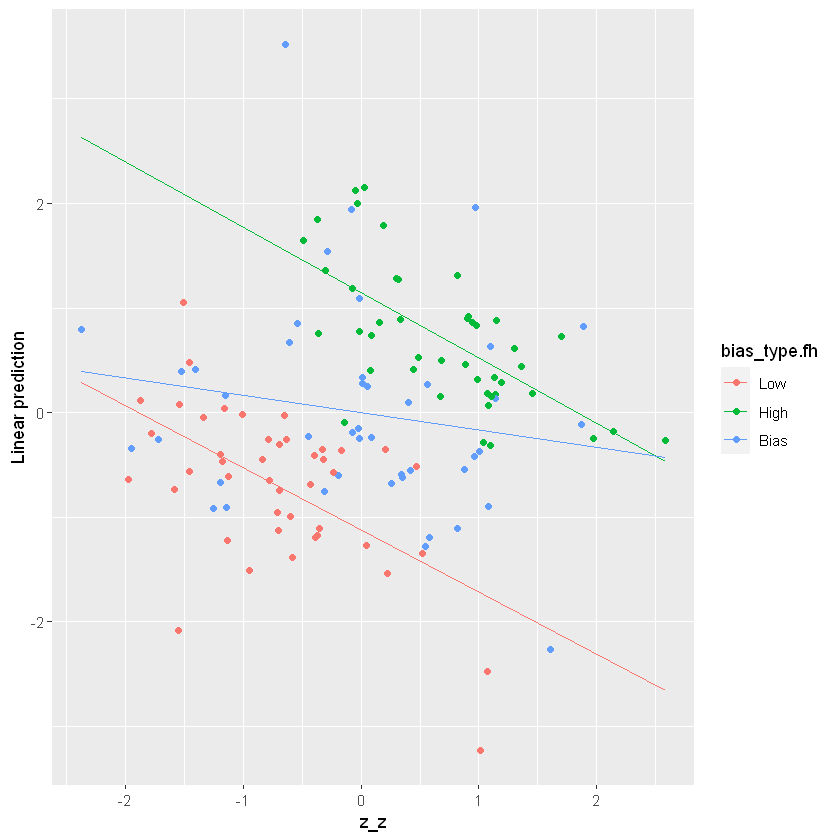

In [10]:
#plot fit
mip_lm.zc <- emmip(bias_lm.zc, bias_type.fh~z_z,cov.reduce=range)
mip_lm.zc  <- mip_lm.zc + geom_point(aes(z_z,z_v,colour=bias_type.fh),data=prior_ptL)
mip_lm.zc

## evidence accumulation bias as predictor, starting point bias as outcome
Doing reverse to demonstrate that choice of predictor/outcome doesn't matter to the result, and to hopefully get a better model fit for confirmation of primary result.

In [11]:
#boundary issues so iteratively reduce

bias_lmr <- lmer(z_z~z_v*bias_type.fh + (1+z_v|subject),prior_ptL,
                  control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5)))
VarCorr(bias_lmr)

boundary (singular) fit: see ?isSingular



 Groups   Name        Std.Dev. Corr  
 subject  (Intercept) 0.22666        
          z_v         0.14256  -1.000
 Residual             0.69063        

In [12]:
bias_lmr.zc <- lmer(z_z~z_v*bias_type.fh + (1+z_v||subject),prior_ptL,
                  control=lmerControl(optimizer="bobyqa",
                                      optCtrl=list(maxfun=2e5)))
VarCorr(bias_lmr.zc)

 Groups    Name        Std.Dev.
 subject   (Intercept) 0.193248
 subject.1 z_v         0.081051
 Residual              0.709788

In [13]:
#result confirmed in a better-behaved model
summary(bias_lmr.zc)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: z_z ~ z_v * bias_type.fh + (1 + z_v || subject)
   Data: prior_ptL
Control: lmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 2e+05))

REML criterion at convergence: 302.3

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.97178 -0.52525  0.05435  0.51983  2.64454 

Random effects:
 Groups    Name        Variance Std.Dev.
 subject   (Intercept) 0.037345 0.19325 
 subject.1 z_v         0.006569 0.08105 
 Residual              0.503799 0.70979 
Number of obs: 132, groups:  subject, 44

Fixed effects:
                   Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)         0.04726    0.08669  64.74036   0.545  0.58749    
z_v                -0.46322    0.08551  22.73545  -5.417 1.73e-05 ***
bias_type.fh1       2.27070    0.21839  99.32471  10.397  < 2e-16 ***
bias_type.fh2      -0.07810    0.15399  98.27135  -0.507  0.61318    
z_v:bias_type.fh1  -0.212

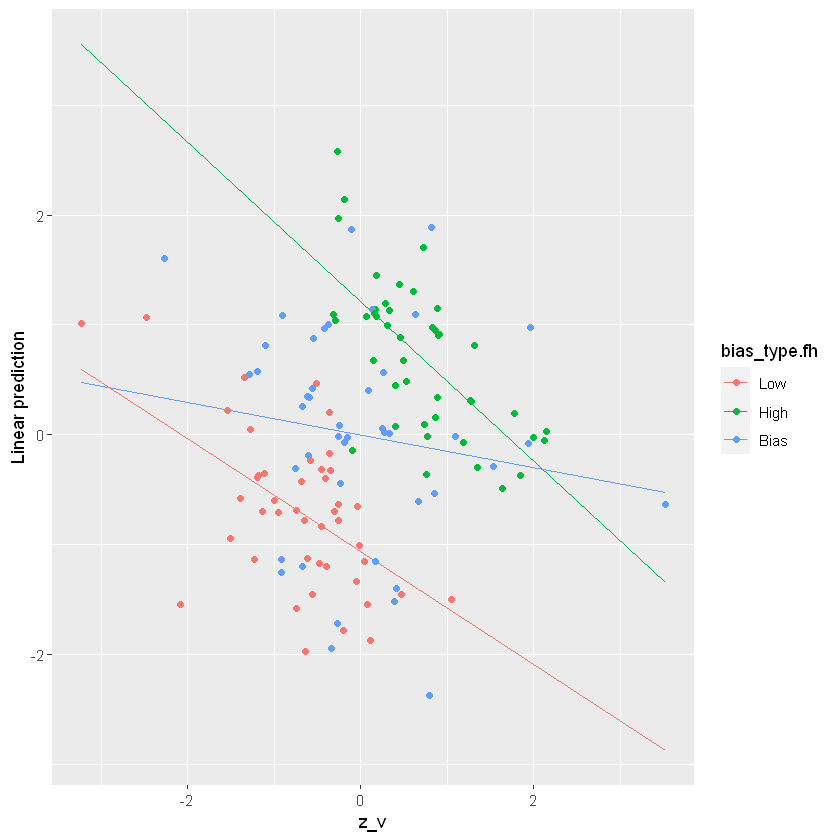

In [14]:
#plot fit
mip_lmr.zc <- emmip(bias_lmr.zc, bias_type.fh~z_v,cov.reduce=range)
mip_lmr.zc <- mip_lmr.zc + geom_point(aes(z_v,z_z,colour=bias_type.fh),data=prior_ptL)
mip_lmr.zc